In [50]:
import os
import csv
import yaml

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors

from cycler import cycler
from scipy.stats import pearsonr
from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
import pandas as pd
import torch

In [2]:
pd.__version__
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

NUM_COLORS = 20
cm = plt.get_cmap('tab20')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
cycler = mpl.rcsetup.cycler(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
plt.rcParams['axes.prop_cycle'] = cycler

In [33]:
pt_fp32 = [
    0.0062215182930231,
    0.0074385223910212,
    0.0099982568994164,
    0.0191283849999308,
    0.03567571118474,
    0.0686487231403589,
    0.1352174865081906,
    0.2746427489444613,
]
ts_fp32 = [
    0.0049002632498741,
    0.0074255360290408,
    0.0108970845118165,
    0.0192750999704003,
    0.0354552909731864,
    0.0667945412918925,
    0.1303580462932586,
    0.2577695468440651,
]
ort_fp32 = [
    0.005027799308300019,
    0.006823857873678207,
    0.010126833617687226,
    0.017962181940674782,
    0.03485818300396204,
    0.06777845006436109,
    0.1318334612995386,
]


pt_fp16 =  [
    0.0062186298891901,
    0.0081064553931355,
    0.0068344635888934,
    0.0082459734752774,
    0.0094524070620536,
    0.0173431253060698,
    0.0309295678511261,
    0.0643264772370457
]

ts_fp16 = [
    0.0031554624438285,
    0.0035669302567839,
    0.0035946331918239,
    0.00557232927531,
    0.0105590904131531,
    0.0175298111513257,
    0.0287821944802999,
    0.0560352109372615,
]
ort_fp16 = [
0.002062009833753109,
0.002650168351829052,
0.0038639172911643983,
0.006124850176274776,
0.010781887173652648,
0.01938758734613657,
0.03503655232489109,
0.07058263774961233
]

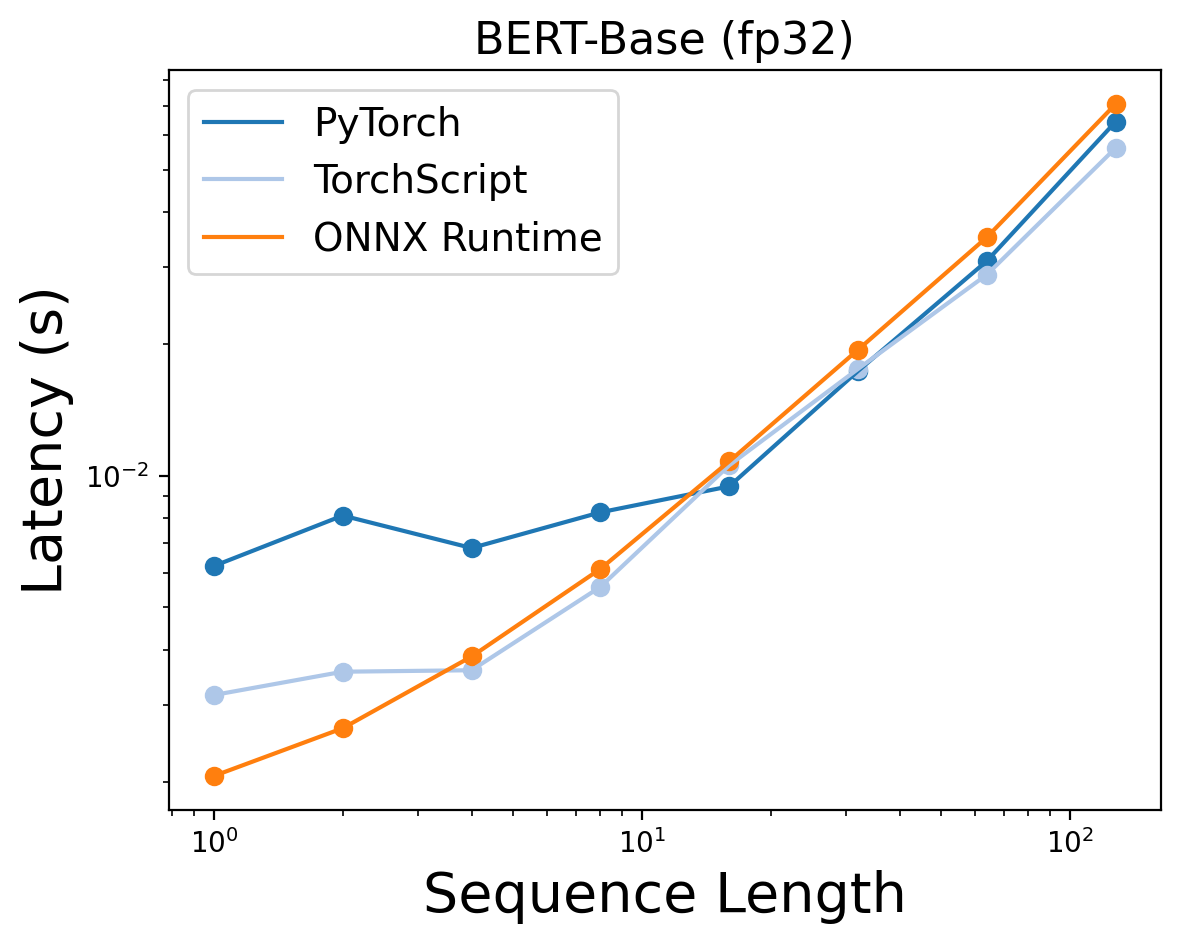

In [49]:
idx = [2**_ for _ in range(8)]
plt.scatter(idx, pt_fp16)
plt.scatter(idx, ts_fp16)
plt.scatter(idx, ort_fp16,)


plt.plot(idx, pt_fp16, label="PyTorch")
plt.plot(idx, ts_fp16, label="TorchScript")
plt.plot(idx, ort_fp16, label="ONNX Runtime")

plt.xlabel("Sequence Length", fontsize=20)
plt.ylabel("Latency (s)", fontsize=20)
plt.yscale("log")
plt.xscale("log")
plt.legend(fontsize=14)
plt.title("BERT-Base (fp32)", fontsize=16)
plt.savefig("seqlen.png", bbox_inches='tight')


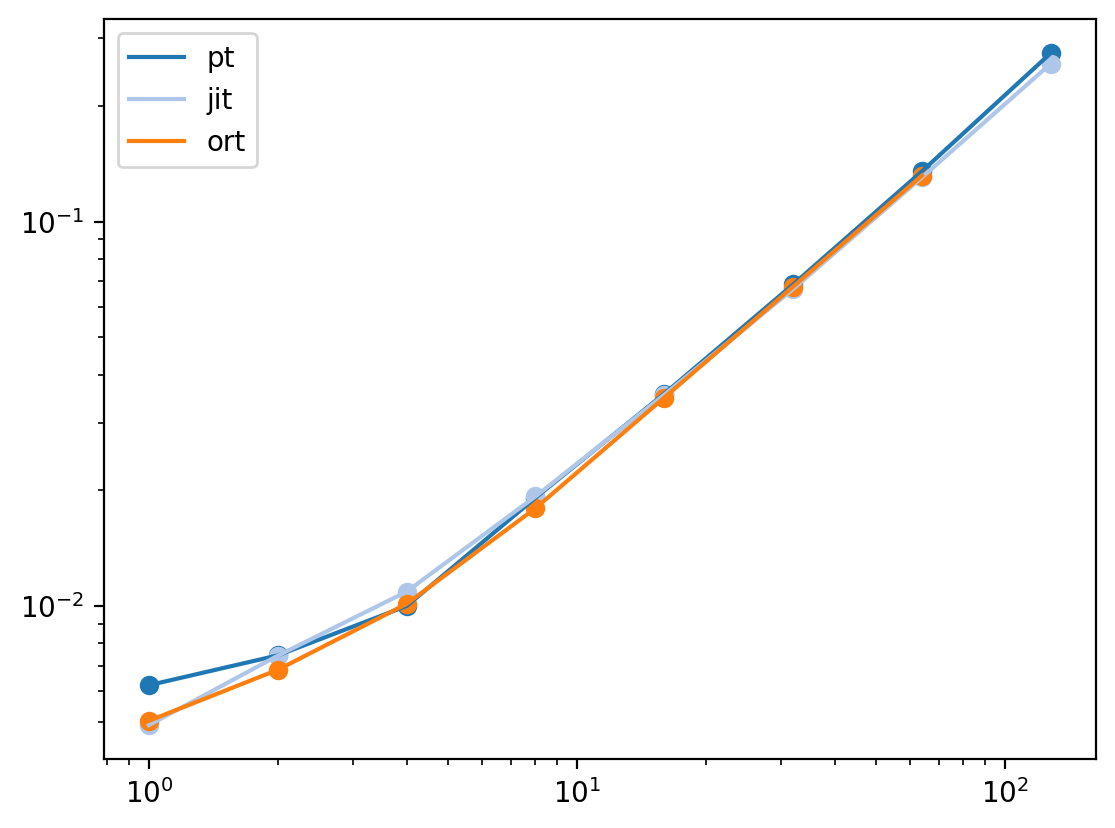

In [18]:
idx = [2**_ for _ in range(8)]
plt.scatter(idx, pt_fp32,)
plt.scatter(idx, ts_fp32)
plt.scatter(idx[:-1], ort_fp32,)

plt.plot(idx, pt_fp32, label="pt")

plt.plot(idx, ts_fp32, label="jit")
plt.plot(idx[:-1], ort_fp32, label="ort")

plt.yscale("log")
plt.xscale("log")
plt.legend()


In [3]:
BASELINE_VISUAL = {
    # "resnet18": "ResNet-18",
    "resnet50": "ResNet-50",
    # "resnet101": "ResNet-101",
    # "resnet152": "ResNet-152",
    "vit32": "ViT32",
}

OTHER_VISUAL = {
    "alexnet": "AlexNet",
    "vgg16": "VGG16",
    "densenet": "DenseNet",
    "inception": "InceptionNet",
    "googlenet": "GoogLeNet",
    "resnext50_32x4d": "ResNext50",
}

EFFICIENT_VISUAL = {
    "wide_resnet50_2": "Wide ResNet-50",
    "efficientnet": "EfficientNet",
    "efficientnet_lite": "EfficientNet Lite",
    # "gernet": "GErNet",
    # "shufflenet": "ShuffleNet",
    # "squeezenet": "SqueezeNet",
    # "mobilenet_v2": "MobileNet v2",
    # "mnasnet": "MNAS Net"
    }

In [4]:
BASELINE_TRANSFORMERS = {
    "bert": "BERT-Base",
#     "roberta": "RoBERTa"
}

OTHER_TRANSFORMERS = {
    'deberta': "DeBERTa",
    'albert': "Albert",
    'ibert': "ibert"
}

EFFICIENT_TRANSFORMERS = {
    # 'albert': "Albert",
    "distilbert": "DistilBERT",
    "mobile_bert": "MobileBERT",
    "squeeze_bert": "SqueezeBERT",
        # 'longformer': "Longformer",

    "funnel_transformer": "Funnel TF"
}

BASELINES_EFFICIENTS = {**BASELINE_TRANSFORMERS,  **EFFICIENT_TRANSFORMERS} # , **BASELINE_VISUAL, **EFFICIENT_VISUAL}

In [42]:
EDGE_DEVICES = {
    "jetson_cpu": "Nvidia Jetson CPU Only",
    "jetson_gpu": "Nvidia Jetson GPU Enabled",
    "rpi4_cpu": "Raspberry Pi 4B",
    "rpi3_cpu": "Raspberry Pi 3",
    "lattepanda": "LattePanda Delta"
}

x86_DEVICES= {
#     "laptop_cpu": "Laptop Intel-i7 (8th Generation)",
#     "herron_cpu": "Server Intel Xeon",
#     "herron_gpu": "Server Nvidia RTX-8000",
}

CONSUMER_GPUS = {
    # "TitanX": "Nvidia TitanX",
    "1080ti": "Nvidia 1080Ti",
    "2080Ti": "Nvidia 2080Ti",
    "3090":  "Nvidia 3090",
}
QUADRO_GPUS = {
    "rtx8000": "Nvidia RTX-8000",
    # "A6000": "Nvidia A6000",
    "v100":  "Nvidia V100",
    "a100":  "Nvidia A100",
}

x86_DEVICES = {**CONSUMER_GPUS, **QUADRO_GPUS, **x86_DEVICES}

In [9]:
LANGUAGE_MODELS = {**EFFICIENT_TRANSFORMERS, **BASELINE_TRANSFORMERS} # **OTHER_TRANSFORMERS }
VISION_MODELS = {**BASELINE_VISUAL, **EFFICIENT_VISUAL, **OTHER_VISUAL}


In [19]:
set(all_results[('1080ti', '2022_1025_pretrained-fp32')]['model'])

{'albert',
 'alexnet',
 'bert',
 'densenet',
 'distilbert',
 'efficientnet',
 'efficientnet_lite',
 'funnel_transformer',
 'googlenet',
 'inception',
 'longformer',
 'mnasnet',
 'mobile_bert',
 'mobilenet_v2',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet50',
 'shufflenet',
 'squeeze_bert',
 'squeezenet',
 'vgg16',
 'vit32',
 'wide_resnet50_2'}

In [88]:
EXP_DIR = "pytorch/experiments/pretrained/"
EXP_LIST = {
    "2023_0623_pretrained-fp32": "PyTorch (fp32)",
    "2023_0623_pretrained-fp16": "PyTorch (fp16)",
    "2023_0623_pretrained-fp32-jit": "TorchScript (fp32)",
    "2023_0623_pretrained-fp16-jit": "TorchScript (fp16)",

    # "2022_1025_pretrained-fp32": "PyTorch (fp32)",
    # "2022_1025_pretrained-fp16": "PyTorch (fp16)",
    # "2022_1025_pretrained-torchscript": "TorchScript (fp32)",
    # "2022_1025_pretrained-torchscript-fp16": "TorchScript (fp16)",
    #     "2022_0917_pretrained-trt": "TensorRT"
}

DEVICE_LIST = x86_DEVICES
# MODEL_LIST = {**LANGUAGE_MODELS, **VISION_MODELS}
MODEL_LIST = {'wavlm': "WavLM"}

all_results = {}
for device, experiment in product(DEVICE_LIST, EXP_LIST):
    results_fname = os.path.join(EXP_DIR, f"{experiment}/{device}.csv")
    print(results_fname)
    if os.path.exists(results_fname):
        all_results[(device, experiment)] = pd.read_csv(results_fname)


pytorch/experiments/pretrained/2023_0623_pretrained-fp32/1080ti.csv
pytorch/experiments/pretrained/2023_0623_pretrained-fp16/1080ti.csv
pytorch/experiments/pretrained/2023_0623_pretrained-fp32-jit/1080ti.csv
pytorch/experiments/pretrained/2023_0623_pretrained-fp16-jit/1080ti.csv
pytorch/experiments/pretrained/2023_0623_pretrained-fp32/2080Ti.csv
pytorch/experiments/pretrained/2023_0623_pretrained-fp16/2080Ti.csv
pytorch/experiments/pretrained/2023_0623_pretrained-fp32-jit/2080Ti.csv
pytorch/experiments/pretrained/2023_0623_pretrained-fp16-jit/2080Ti.csv
pytorch/experiments/pretrained/2023_0623_pretrained-fp32/3090.csv
pytorch/experiments/pretrained/2023_0623_pretrained-fp16/3090.csv
pytorch/experiments/pretrained/2023_0623_pretrained-fp32-jit/3090.csv
pytorch/experiments/pretrained/2023_0623_pretrained-fp16-jit/3090.csv
pytorch/experiments/pretrained/2023_0623_pretrained-fp32/rtx8000.csv
pytorch/experiments/pretrained/2023_0623_pretrained-fp16/rtx8000.csv
pytorch/experiments/pretrained

In [47]:
all_results.keys()

dict_keys([('rtx8000', '2023_0623_pretrained-fp32'), ('rtx8000', '2023_0623_pretrained-fp16')])

In [49]:
# x = np.array(x).reshape(10,1)
# y = np.array(y)


device_flops = {
    "1080ti": 22.78,
    "2080Ti": 26.9,
    "3090":  35.89,
    "RTX-8000": 32.62,
    # "A6000": 38.71,
    "v100":  28.26,
    "a100":  77.97
}
# models = set(all_results[('rtx8000', 'wavlm')]['model'])
for model in ['wavlm']:
    for device, flops in device_flops.items():
        results = all_results[(device, '2022_1025_pretrained-fp16')]
        latency = results[(results['batch_size'] == 1) & (results['model'] == model)]['latency']
        print(flops, latency, model, device)
        plt.scatter(flops, latency, label=x86_DEVICES[device])

# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Latency')
plt.xlabel('FLOP per Second')
# plt.legend()
plt.show()


KeyError: ('1080ti', '2022_1025_pretrained-fp16')

In [24]:
results.keys()

dict_keys([('rtx8000', '2023_0620_pretrained-fp32'), ('rtx8000', '2023_0620_pretrained-fp16')])

In [22]:
results = all_results[('rtx8000', '2023_0620_pretrained-fp32')]
for bs in [1, 64]:
    bs1 = results[(results['batch_size'] == bs) & results['model'].isin(BASELINES_EFFICIENTS)]

    x, y= [], []
    for macs, lat, model, params in zip(bs1['macs'], bs1['latency'], bs1['model'], bs1['max_params']):
        plt.scatter(macs / bs , lat, label=f"{model} {bs}") # , s=params / bert_params)
        x.append(macs)
        y.append(lat)
        print(model)

plt.xlabel('MACS')
plt.ylabel('Latency')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


KeyError: ('rtx8000', '2023_0620_pretrained-fp32')

In [10]:
device_specs = {}
for device in DEVICE_LIST:
    spec_fname = f"pytorch/config/devices/specs/{device}.yaml"
    if os.path.exists(spec_fname):
        device_specs[device] = yaml.safe_load(open(spec_fname, "rb"))


In [23]:
resnet50_onnx_rtx_fp16 = [0.002765, 0.002747, 0.003265, 0.005080, 0.009168, 0.018601, 0.041582, 0.090903]
resnet50_onnx_rtx_fp32 = [0.003217, 0.003852,0.005790, 0.010421, 0.019034, 0.035602, 0.065791, 0.131595]

resnet50_onnx_rtx_graph0 = [0.003876, 0.005238, 0.005732, 0.010476, 0.019234, 0.037037, 0.071567, 0.132319]
resnet50_onnx_rtx_graph1 = [0.003455, 0.003948, 0.005777, 0.010735, 0.019238, 0.037627, 0.072495, 0.132335]
resnet50_onnx_rtx_graph2 = [0.003483, 0.003869, 0.005793, 0.010375, 0.019229, 0.037384, 0.065457, 0.131582]
resnet50_onnx_rtx_graph3 = [0.003433, 0.00399, 0.005803, 0.010506, 0.019154, 0.037648, 0.071955, 0.132166]

resnet50_onnx_rtx_graph2_fp16 = [0.003483, 0.003869, 0.005793, 0.010375, 0.019229, 0.037384, 0.065457, 0.131582]

bert_onnx_rtx_fp32_0 = [0.010950, 0.011999, 0.016494, 0.028262, 0.051380, 0.097615, 0.188400, 0.364865]
bert_onnx_rtx_fp32_1 = [0.006947, 0.008174, 0.013187, 0.024532, 0.047394, 0.093053, 0.181236, 0.361474]
bert_onnx_rtx_fp32_2 = [0.004229, 0.005596, 0.009483, 0.018003, 0.036070, 0.070098, 0.136608, 0.269475]

# Check if this is actually applying opts
bert_onnx_rtx_fp16_0 = [0.002695, 0.002729, 0.003152, 0.004702, 0.008957, 0.019444, 0.034650, 0.066872]
bert_onnx_rtx_fp16_1 = [0.002597, 0.002599, 0.003223, 0.004843, 0.009054, 0.017996, 0.034850, 0.075597]
bert_onnx_rtx_fp16_2 = [0.002556, 0.002752, 0.003557, 0.004689, 0.008638, 0.017558, 0.033410, 0.062093]

vit32_onnx_rtx_fp32_1 = [0.006878, 0.007388, 0.008778, 0.012500, 0.021731, 0.038857, 0.073924, 0.144218]
vit32_onnx_rtx_fp32_2 = [0.004019, 0.004744, 0.006049, 0.009277, 0.016799, 0.030277, 0.057058, 0.110164]
vit32_onnx_rtx_fp16_1 = [0.007110, 0.006711, 0.006937, 0.007600, 0.009588, 0.015901, 0.030268, 0.057799]
vit32_onnx_rtx_fp16_2 = [0.004113, 0.004188, 0.004074, 0.004580, 0.005767, 0.009777, 0.018156,0.033326]

onnx_results = {'bert': [bert_onnx_rtx_fp16_1, bert_onnx_rtx_fp32_2], 'resnet50': [resnet50_onnx_rtx_fp16, resnet50_onnx_rtx_fp32]}
# onnx_results = {'bert': [bert_onnx_rtx_fp16_1, bert_onnx_rtx_fp32_0], 'resnet50': [resnet50_onnx_rtx_fp16, resnet50_onnx_rtx_graph0]}

batch_size = [2**_ for _ in range(8)]


NameError: name 'all_results' is not defined

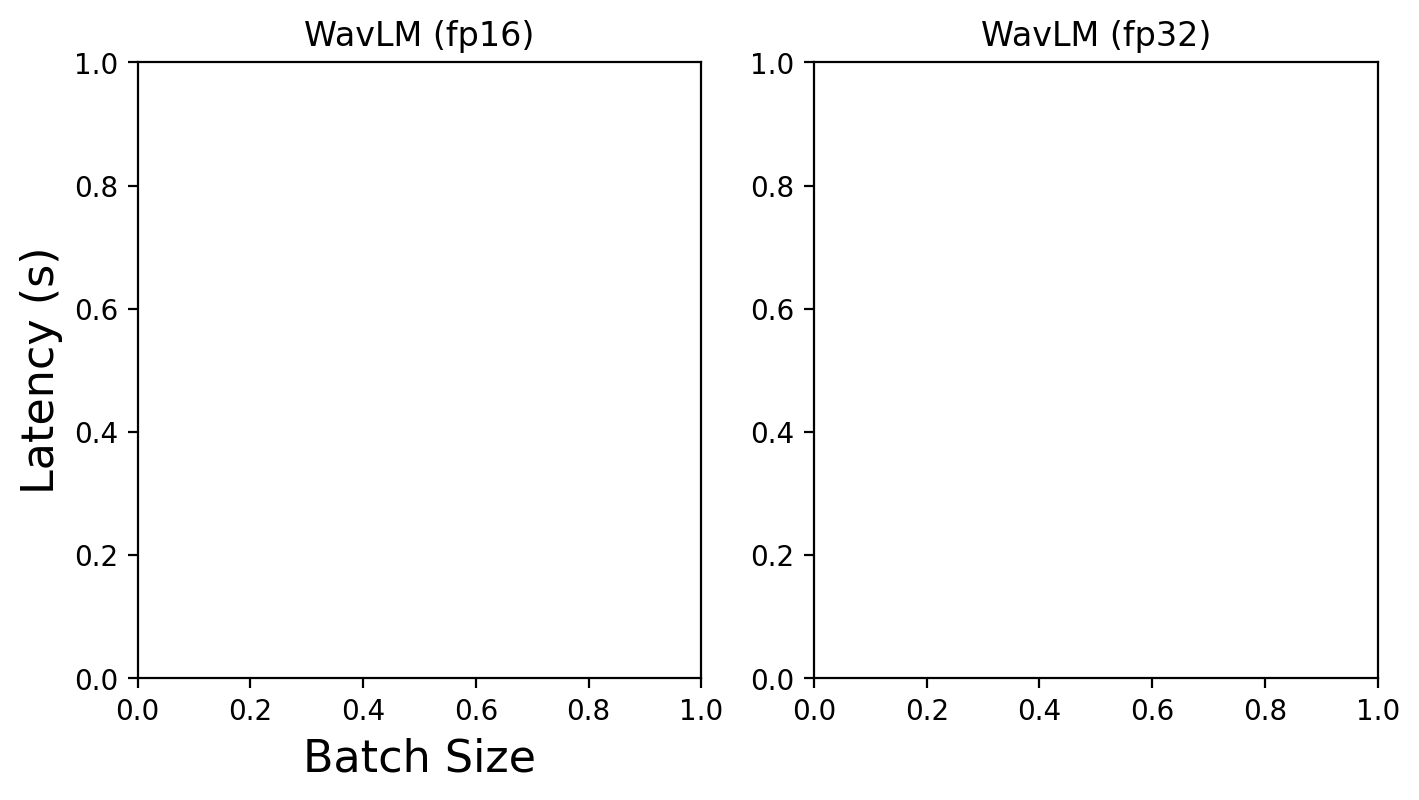

In [51]:
batch_sizes = [2**_ for _ in range(8)]
model = "wavlm"
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)#  figsize=(5,10))
# plt.set_width(5)
plt.xlabel('Batch Size', fontsize=16)
plt.ylabel('Latency (s)', fontsize=16)
# plt.figsize(5,10)
plt.title("WavLM (fp16)")
plt.subplot(1,2,2)
plt.title("WavLM (fp32)")

for ix, prec in enumerate(['fp16', 'fp32']):

    plt.subplot(1,2,ix + 1)
    exp_result = all_results[('rtx8000', f'2023_0623_pretrained-{prec}')]
    bert_results = exp_result[exp_result['model'] == model]['latency'][-8:]
    plt.scatter(batch_sizes, bert_results, label=f"PyTorch")
    plt.plot(batch_sizes, bert_results)
    plt.yscale('log')
    plt.xscale('log')
    print(bert_results)

    exp_result = all_results[('rtx8000', f'2023_0623_pretrained-{prec}-jit')]
    bert_jit_results = model_results = exp_result[exp_result['model'] == model]['latency'][-8:]
    plt.scatter(batch_sizes, bert_jit_results, label=f"TorchScript")
    plt.plot(batch_sizes, bert_jit_results)
    plt.yscale('log')
    plt.xscale('log')
    print(bert_results)

# onnx_results = [bert_onnx_rtx_fp32_0, bert_onnx_rtx_fp32_1, bert_onnx_rtx_fp32_2]
# onnx_results = [bert_onnx_rtx_fp16_0, bert_onnx_rtx_fp16_1, bert_onnx_rtx_fp16_2]
# onnx_results = [resnet50_onnx_rtx_graph0, resnet50_onnx_rtx_graph1]

# plt.plot(batch_sizes, onnx_results[0])
# plt.scatter(batch_sizes, onnx_results, label="ONNX without Graph Opt")

# # plt.plot(batch_sizes, onnx_results[2])
# # plt.scatter(batch_sizes, onnx_results[2], label="ONNX with Graph Opt")
# plt.title("ResNet-50", fontsize=20)

# plt.plot(batch_sizes, onnx_results[2])
# plt.scatter(batch_sizes, onnx_results[2], label="Embedding Fusion")

plt.legend()
plt.xlabel('Batch Size', fontsize=16)

plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.savefig("speech.pdf", bbox_inches="tight")

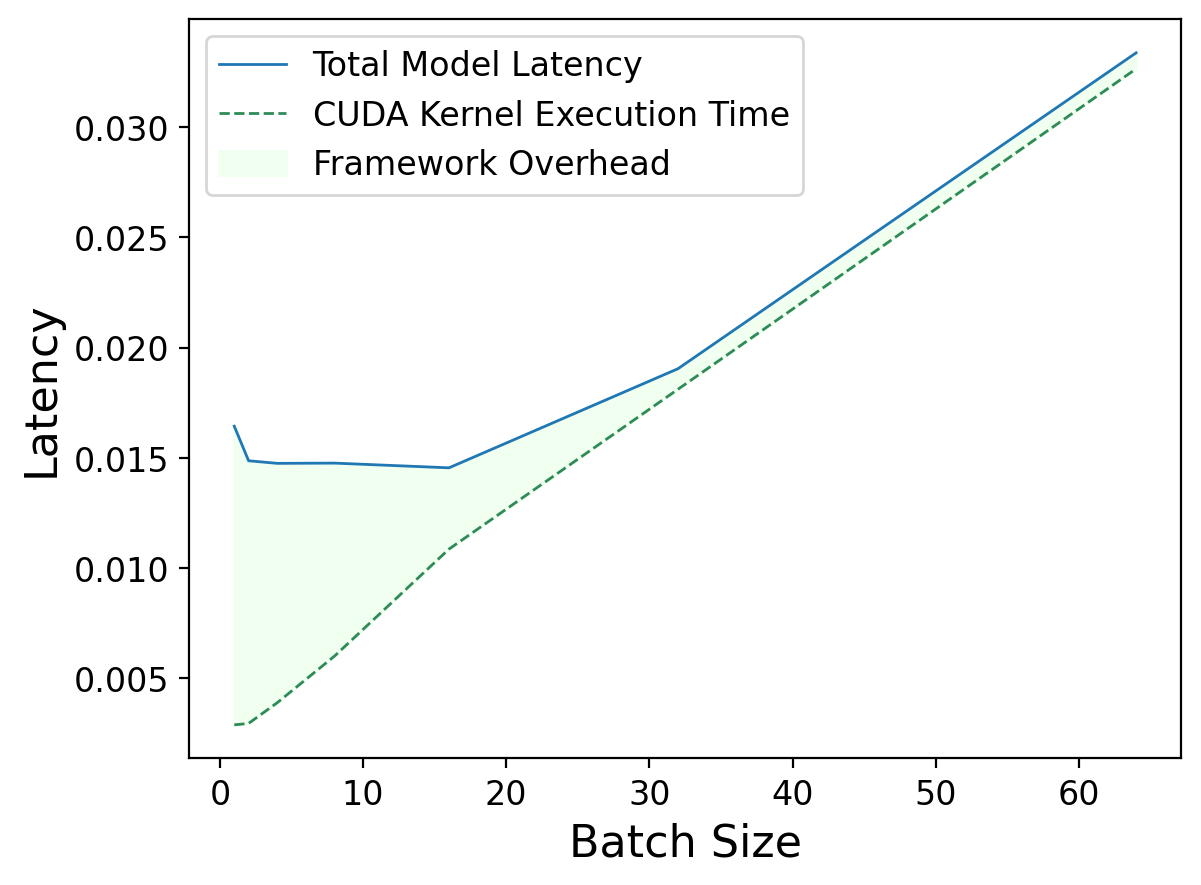

In [43]:
# Framework Overhead Figure
total_time = [0.02221, 0.02244, 0.02021, 0.02124, 0.02152, 0.03742, 0.070282, 0.1367][:-1]
cuda_jit_time = [0.003668, 0.004431, 0.006439, 0.01124, 0.019303, 0.035598, 0.067929, 0.1338][:-1]

total_time = np.array([16.437, 14.87, 14.753, 14.7635, 14.5499, 19.0459, 33.3723]) / 1000
cuda_jit_time = np.array([2.892, 2.956, 3.895, 6.0092, 10.8632, 18.114, 32.6478]) / 1000

# 15.257, 14.752ms
# 5.405ms, 11.672ms
batch_sizes = [2 ** _ for _ in range(7)]

plt.plot(batch_sizes, total_time, linewidth=1, label="Total Model Latency")
plt.plot(batch_sizes, cuda_jit_time, '--', linewidth=1, label="CUDA Kernel Execution Time", color='seagreen')
plt.fill_between(batch_sizes, total_time, cuda_jit_time, label="Framework Overhead", color='honeydew')
plt.xlabel('Batch Size', fontsize=16)
plt.ylabel('Latency', fontsize=16)


plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.legend(fontsize=12)
plt.savefig("framework-overhead.pdf",  bbox_inches='tight')

dict_keys([('RTX-8000', '2022_1025_pretrained-fp32'), ('RTX-8000', '2022_1025_pretrained-fp16'), ('RTX-8000', '2022_1025_pretrained-torchscript'), ('RTX-8000', '2022_1025_pretrained-torchscript-fp16')])

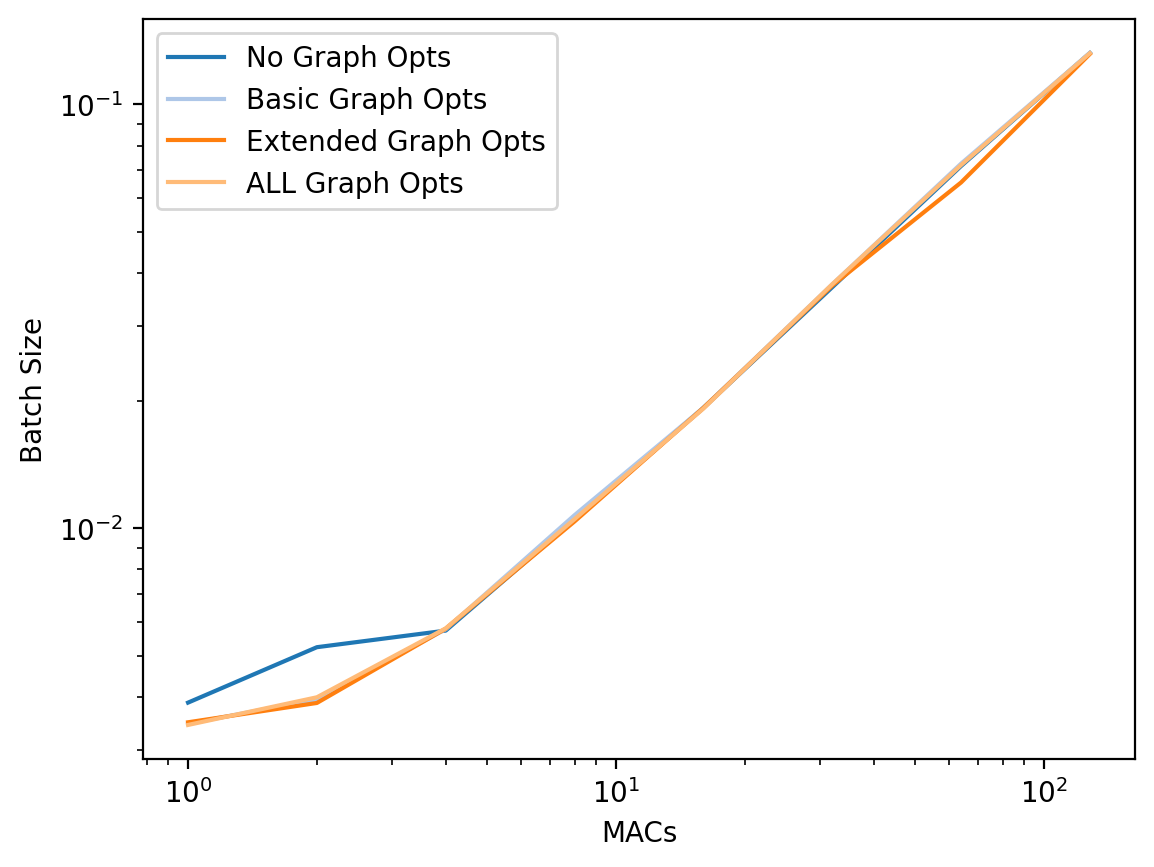

In [63]:
plt.plot(batch_size, resnet50_onnx_rtx_graph0, label="No Graph Opts")
plt.plot(batch_size, resnet50_onnx_rtx_graph1, label="Basic Graph Opts")
plt.plot(batch_size, resnet50_onnx_rtx_graph2, label="Extended Graph Opts")
plt.plot(batch_size, resnet50_onnx_rtx_graph3, label="ALL Graph Opts")
plt.ylabel('Batch Size')
plt.xlabel('MACs')
plt.yscale('log')
plt.xscale('log')
plt.legend()
all_results.keys()